In [18]:
%load_ext autoreload
%autoreload 2

In [19]:
import os
import math
import wave
import array
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import ffmpeg
import yt_dlp
import pywt
from scipy import signal
from pydub import AudioSegment

In [20]:
def download_youtube_audio(url, output_folder="downloads"):
    ydl_opts = {
        'outtmpl': f'{output_folder}/%(title)s.%(ext)s',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'mp3',
            'preferredquality': '192',
        }],
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        result = ydl.download([url])
    return f"{ydl.prepare_filename(ydl.extract_info(url, download=False)).replace('.webm', '.mp3')}"

def convert_mp3_to_wav(mp3_file_path):
    if not os.path.exists(mp3_file_path):
        raise FileNotFoundError(f"File {mp3_file_path} does not exist.")
    audio = AudioSegment.from_mp3(mp3_file_path)
    wav_file_path = os.path.splitext(mp3_file_path)[0] + '.wav'
    audio.export(wav_file_path, format="wav")
    return wav_file_path


In [21]:
def read_wav(filename):
    try:
        wf = wave.open(filename, "rb")
    except IOError as e:
        print(e)
        return
    nsamps = wf.getnframes()
    assert nsamps > 0

    fs = wf.getframerate()
    assert fs > 0
    samps = list(array.array("i", wf.readframes(nsamps)))

    try:
        assert nsamps == len(samps)
    except AssertionError:
        print(nsamps, "not equal to", len(samps))

    return samps, fs

def no_audio_data():
    print("No audio data for sample, skipping...")
    return None, None

def peak_detect(data):
    max_val = np.amax(abs(data))
    peak_ndx = np.where(data == max_val)
    if len(peak_ndx[0]) == 0:  
        peak_ndx = np.where(data == -max_val)
    return peak_ndx

# From https://github.com/scaperot/the-BPM-detector-python/tree/master
def bpm_detector(data, fs):
    cA = []
    cD = []
    correl = []
    cD_sum = []
    levels = 4
    max_decimation = 2 ** (levels - 1)
    min_ndx = math.floor(60.0 / 220 * (fs / max_decimation))
    max_ndx = math.floor(60.0 / 40 * (fs / max_decimation))

    for loop in range(0, levels):
        cD = []
        # 1) DWT
        if loop == 0:
            [cA, cD] = pywt.dwt(data, "db4")
            cD_minlen = len(cD) / max_decimation + 1
            cD_sum = np.zeros(math.floor(cD_minlen))
        else:
            [cA, cD] = pywt.dwt(cA, "db4")
        # 2) Filter
        cD = signal.lfilter([0.01], [1 - 0.99], cD)
        # 4) Subtract out the mean and
        # 5) Decimate for reconstruction later.
        cD = abs(cD[:: (2 ** (levels - loop - 1))])
        cD = cD - np.mean(cD)
        # 6) Recombine the signal before ACF
        cD_sum = cD[0 : math.floor(cD_minlen)] + cD_sum

    if [b for b in cA if b != 0.0] == []:
        return no_audio_data()

    cA = signal.lfilter([0.01], [1 - 0.99], cA)
    cA = abs(cA)
    cA = cA - np.mean(cA)
    cD_sum = cA[0 : math.floor(cD_minlen)] + cD_sum

    # ACF
    correl = np.correlate(cD_sum, cD_sum, "full")

    midpoint = math.floor(len(correl) / 2)
    correl_midpoint_tmp = correl[midpoint:]
    peak_ndx = peak_detect(correl_midpoint_tmp[min_ndx:max_ndx])
    if len(peak_ndx) > 1:
        return no_audio_data()

    peak_ndx_adjusted = peak_ndx[0] + min_ndx
    bpm = 60.0 / peak_ndx_adjusted * (fs / max_decimation)
    return bpm, correl

def get_bpm(filename, sample_rate, draw_graph = True):
    samps, fs = read_wav(filename)
    data = []
    correl = []
    bpm = 0
    n = 0
    nsamps = len(samps)
    window_samps = int(sample_rate * fs)
    samps_ndx = 0  
    max_window_ndx = math.floor(nsamps / window_samps)
    bpms = np.zeros(max_window_ndx)

    for window_ndx in range(0, max_window_ndx):
        data = samps[samps_ndx : samps_ndx + window_samps]
        if not ((len(data) % window_samps) == 0):
            raise AssertionError(str(len(data)))

        bpm, correl_temp = bpm_detector(data, fs)
        if bpm is None:
            continue
        bpms[window_ndx] = bpm
        correl = correl_temp
        samps_ndx = samps_ndx + window_samps
        n = n + 1
    bpm = np.median(bpms)
    # print("Completed!  Estimated Beats Per Minute:", bpm)

    if draw_graph:
        n = range(0, len(bpms))
        plt.plot(n, abs(bpms))
        plt.show(block=True)
    return bpms

In [13]:
def detect_bpm_changes(bpms, sample_rate):
    bpm_changes = {0 : round(float(bpms[0]),2)}
    prev_bpm = bpms[0]
    
    for i, bpm in enumerate(bpms):
        if abs(bpm - prev_bpm) > 20:
            bpm_changes[i * sample_rate] = round(float(bpm),2)
            prev_bpm = bpm  # Update previous BPM
    return bpm_changes

def get_moves(moves_audio_dir):
    moves_bpms = {}
    for file in os.listdir(moves_audio_dir):
        if file.endswith(".wav"):
            wav_path = os.path.join(moves_audio_dir, file)
            sample_rate = 1
            bpms = get_bpm(wav_path, sample_rate, False)
            bpm = np.median(bpms)
            file = file[:-4]
            moves_bpms[file] = round(float(bpm), 2)
    return moves_bpms

In [22]:
def find_best_match(target_bpm, moves_bpms):
    return min(moves_bpms.keys(), key=lambda m: abs(moves_bpms[m] - target_bpm))

def create_dance(bmp_map, moves_bpms, output_video, moves_dir, wav_path):
    sorted_bpm_keys = sorted(bmp_map.keys())
    temp_videos = []
    for i in range(len(sorted_bpm_keys) - 1):
        start_time = sorted_bpm_keys[i]
        end_time = sorted_bpm_keys[i + 1]
        target_bpm = bmp_map[start_time]

        best_move = find_best_match(target_bpm, moves_bpms)
        move_bpm = moves_bpms[best_move]
        video_path = os.path.join(moves_dir, f"{best_move}.mp4")

        if not os.path.exists(video_path):
            print(f"Warning: {video_path} not found. Skipping...")
            continue
        speed_factor = move_bpm / target_bpm
        temp_file = f"temp_{i}.mp4"
        temp_videos.append(temp_file)
        (
            ffmpeg.input(video_path)
            .filter("setpts", f"{1/speed_factor}*PTS")  # Adjust speed
            .output(temp_file, vcodec="libx264", preset="ultrafast", an=None)  # Remove audio
            .run(overwrite_output=True, quiet=True)
        )

    with open("file_list.txt", "w") as f:
        for temp_file in temp_videos:
            f.write(f"file '{temp_file}'\n")

    concat_video = "temp_concat.mp4"
    ffmpeg.input("file_list.txt", format="concat", safe=0).output(concat_video, vcodec="libx264", preset="ultrafast").run(overwrite_output=True, quiet=True)

    ffmpeg.output(ffmpeg.input(concat_video), ffmpeg.input(wav_path), output_video, vcodec="libx264", acodec="aac", preset="ultrafast").run(overwrite_output=True, quiet=True)
    for temp_file in temp_videos:
        os.remove(temp_file)
    os.remove("file_list.txt")
    os.remove(concat_video)
    print(f"Final dance video saved as {output_video}")

In [23]:
def youtube_link_to_just_dance(youtube_link):
    moves_audio_dir = "moves_audio"
    moves_dir = "moves"
    output_video = "final_dance.mp4"
    mp3_path = download_youtube_audio(youtube_link)
    wav_path = convert_mp3_to_wav(mp3_path)
    sample_rate = 10
    bpms = get_bpm(wav_path, sample_rate)
    bpm_map = detect_bpm_changes(bpms, sample_rate)
    print("BPM Map for given song")
    pprint(bpm_map)
    moves_bpms = get_moves(moves_audio_dir)
    create_dance(bpm_map, moves_bpms, output_video, moves_dir, wav_path)

[youtube] Extracting URL: https://www.youtube.com/watch?v=JBe0yHNEURo
[youtube] JBe0yHNEURo: Downloading webpage
[youtube] JBe0yHNEURo: Downloading tv client config
[youtube] JBe0yHNEURo: Downloading player c8dbda2a
[youtube] JBe0yHNEURo: Downloading tv player API JSON
[youtube] JBe0yHNEURo: Downloading ios player API JSON
[youtube] JBe0yHNEURo: Downloading m3u8 information
[info] JBe0yHNEURo: Downloading 1 format(s): 399+251
[download] Destination: downloads/GAYLE - abcdefu.f399.mp4
[download] 100% of    8.85MiB in 00:00:07 at 1.26MiB/s   
[download] Destination: downloads/GAYLE - abcdefu.f251.webm
[download] 100% of    2.60MiB in 00:00:02 at 1.14MiB/s   
[Merger] Merging formats into "downloads/GAYLE - abcdefu.webm"
Deleting original file downloads/GAYLE - abcdefu.f251.webm (pass -k to keep)
Deleting original file downloads/GAYLE - abcdefu.f399.mp4 (pass -k to keep)
[ExtractAudio] Destination: downloads/GAYLE - abcdefu.mp3
Deleting original file downloads/GAYLE - abcdefu.webm (pass -

/var/folders/_2/r3sv5z5j2412qlj71lzgbsmh0000gn/T/ipykernel_81122/299650084.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bpms[window_ndx] = bpm


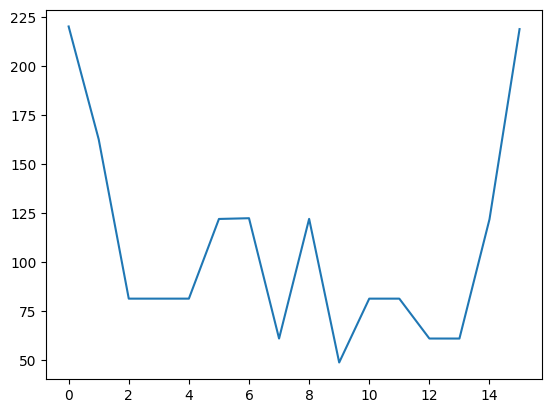

BPM Map for given song
{0: 220.05,
 10: 162.53,
 20: 81.34,
 50: 121.95,
 70: 61.01,
 80: 121.99,
 90: 48.8,
 100: 81.34,
 120: 61.01,
 140: 121.79,
 150: 218.71}
Completed!  Estimated Beats Per Minute: 189.18021080222647
Completed!  Estimated Beats Per Minute: 184.42666512697838
Completed!  Estimated Beats Per Minute: 184.28462942610926
Completed!  Estimated Beats Per Minute: 184.80492813141683
Completed!  Estimated Beats Per Minute: 182.0020222446916
Completed!  Estimated Beats Per Minute: 204.08163265306123
Completed!  Estimated Beats Per Minute: 187.86143287602283
Completed!  Estimated Beats Per Minute: 204.41753863412183
Final dance video saved as final_dance.mp4


In [26]:
youtube_link_to_just_dance(youtube_link= "https://www.youtube.com/watch?v=JBe0yHNEURo")